In [47]:
import pandas as pd

df_income = pd.read_csv('../data/low_income_classification_by_year.csv')

df_income_subset = df_income[['zip_code', 'msa_name', 'year', 'income']]

df_college = pd.read_csv('../data/college_educated_classification_gentrified_overtime.csv')

df_college_subset = df_college[['zip_code', 'msa_name', 'year', 'per_college_educated']]

df_rent_2011 = pd.read_csv('../data/rent_2011.csv')

df_rent_2011 = df_rent_2011[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

df_rent_later = pd.read_csv('../data/rent_2012_2023.csv')

df_rent_later = df_rent_later[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

df_rent = pd.concat([df_rent_later, df_rent_2011], ignore_index=True)

df_rent = df_rent.dropna(axis=1, how='any')

df = pd.merge(df_income_subset, df_college_subset, on=['zip_code', 'msa_name', 'year'], how='left')

df = pd.merge(df, df_rent, on=['zip_code', 'msa_name', 'year'], how='left')

df['zip_code'] = df['zip_code'].astype(str).str.zfill(5)

df = df.dropna()

df

,zip_code,msa_name,year,income,per_college_educated,median_contract_rent
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.100000,2869.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.000000,5897.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.700000,2055.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.700000,272.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.200000,5257.0
...,...,...,...,...,...,...
199409,99705,"Fairbanks, AK MSA",2023,96966.0,23.235542,1702.0
199410,99709,"Fairbanks, AK MSA",2023,82991.0,39.784946,4452.0
199411,99712,"Fairbanks, AK MSA",2023,103494.0,34.573561,683.0
199412,99714,"Fairbanks, AK MSA",2023,71042.0,24.044734,38.0


In [48]:
df_start = df[df['year'] == 2012].copy()
df_end = df[df['year'] == 2022].copy()

df_start = df_start.rename(columns={
    'income': 'income_2012',
    'per_college_educated': 'college_2012',
    'median_contract_rent': 'rent_2012'
})

df_end = df_end.rename(columns={
    'income': 'income_2022',
    'per_college_educated': 'college_2022',
    'median_contract_rent': 'rent_2022'
})

df_merged = pd.merge(df_start, df_end, on=['zip_code', 'msa_name'], how='inner')

df_merged

,zip_code,msa_name,year_x,income_2012,college_2012,rent_2012,year_y,income_2022,college_2022,rent_2022
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.1,2869.0,2022,20260.0,20.575270,3147.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.0,5897.0,2022,17703.0,22.823391,8366.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.7,2055.0,2022,22796.0,21.915303,2389.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.7,272.0,2022,15658.0,28.327645,202.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.2,5257.0,2022,20283.0,24.169736,5551.0
...,...,...,...,...,...,...,...,...,...,...
16353,99705,"Fairbanks, AK MSA",2012,80606.0,18.1,1955.0,2022,88788.0,23.022390,1742.0
16354,99709,"Fairbanks, AK MSA",2012,72900.0,39.6,4365.0,2022,80467.0,40.215682,4455.0
16355,99712,"Fairbanks, AK MSA",2012,88716.0,34.3,818.0,2022,105787.0,31.573135,750.0
16356,99714,"Fairbanks, AK MSA",2012,69219.0,34.7,119.0,2022,66250.0,29.319955,45.0


In [49]:
df_merged['income_change'] = df_merged['income_2022'] - df_merged['income_2012']
df_merged['rent_change'] = df_merged['rent_2022'] - df_merged['rent_2012']
df_merged['college_change'] = df_merged['college_2022'] - df_merged['college_2012']

msa_medians = df_merged.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()
msa_medians = msa_medians.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

df_final = pd.merge(df_merged, msa_medians, on='msa_name', how='left')

In [50]:
df_final['gentrified'] = (
    (df_final['income_change'] > df_final['msa_income_median']) &
    (df_final['rent_change'] > df_final['msa_rent_median']) &
    (df_final['college_change'] > df_final['msa_college_median'])
).astype(int)

df_final

,zip_code,msa_name,year_x,income_2012,college_2012,rent_2012,year_y,income_2022,college_2022,rent_2022,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.1,2869.0,2022,20260.0,20.575270,3147.0,5154.0,278.0,0.475270,5673.0,314.0,3.181886,0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.0,5897.0,2022,17703.0,22.823391,8366.0,2624.0,2469.0,1.823391,5673.0,314.0,3.181886,0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.7,2055.0,2022,22796.0,21.915303,2389.0,5873.0,334.0,7.215303,5673.0,314.0,3.181886,1
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.7,272.0,2022,15658.0,28.327645,202.0,4007.0,-70.0,13.627645,5673.0,314.0,3.181886,0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.2,5257.0,2022,20283.0,24.169736,5551.0,5548.0,294.0,6.969736,5673.0,314.0,3.181886,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16353,99705,"Fairbanks, AK MSA",2012,80606.0,18.1,1955.0,2022,88788.0,23.022390,1742.0,8182.0,-213.0,4.922390,8789.5,-12.0,-1.967382,0
16354,99709,"Fairbanks, AK MSA",2012,72900.0,39.6,4365.0,2022,80467.0,40.215682,4455.0,7567.0,90.0,0.615682,8789.5,-12.0,-1.967382,0
16355,99712,"Fairbanks, AK MSA",2012,88716.0,34.3,818.0,2022,105787.0,31.573135,750.0,17071.0,-68.0,-2.726865,8789.5,-12.0,-1.967382,0
16356,99714,"Fairbanks, AK MSA",2012,69219.0,34.7,119.0,2022,66250.0,29.319955,45.0,-2969.0,-74.0,-5.380045,8789.5,-12.0,-1.967382,0


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

smote = SMOTE()

test_df = df_final[df_final['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

X = test_df[['income_2012', 'rent_2012', 'college_2012']]
X.columns = ['income', 'rent', 'college']
y = test_df['gentrified']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
model = LogisticRegression(penalty='l2', C=0.1,class_weight='balanced',max_iter=1000)

pipeline = make_pipeline(scaler, model)
pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])

In [52]:
df_start_t = df[df['year'] == 2013].copy()
df_end_t = df[df['year'] == 2023].copy()

df_start_t = df_start_t.rename(columns={
    'income': 'income_2013',
    'per_college_educated': 'college_2013',
    'median_contract_rent': 'rent_2013'
})

df_end_t = df_end_t.rename(columns={
    'income': 'income_2023',
    'per_college_educated': 'college_2023',
    'median_contract_rent': 'rent_2023'
})

df_merged_t = pd.merge(df_start_t, df_end_t, on=['zip_code', 'msa_name'], how='inner')

df_merged_t

,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0
...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0


In [53]:
df_merged_t['income_change'] = df_merged_t['income_2023'] - df_merged_t['income_2013']
df_merged_t['rent_change'] = df_merged_t['rent_2023'] - df_merged_t['rent_2013']
df_merged_t['college_change'] = df_merged_t['college_2023'] - df_merged_t['college_2013']

msa_medians_t = df_merged_t.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()
msa_medians_t = msa_medians_t.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

df_test_t = pd.merge(df_merged_t, msa_medians_t, on='msa_name', how='left')

In [54]:
df_test_t['gentrified'] = (
    (df_test_t['income_change'] > df_test_t['msa_income_median']) &
    (df_test_t['rent_change'] > df_test_t['msa_rent_median']) &
    (df_test_t['college_change'] > df_test_t['msa_college_median'])
).astype(int)

df_test_t

,zip_code,msa_name,year_x,income_2013,college_2013,rent_2013,year_y,income_2023,college_2023,rent_2023,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15663.0,20.1,2880.0,2023,21702.0,22.547348,3103.0,6039.0,223.0,2.447348,6286.0,222.0,3.828907,0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15485.0,20.9,6168.0,2023,19243.0,23.917408,8389.0,3758.0,2221.0,3.017408,6286.0,222.0,3.828907,0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,16707.0,13.8,2202.0,2023,23732.0,23.986928,2423.0,7025.0,221.0,10.186928,6286.0,222.0,3.828907,0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,11596.0,15.6,292.0,2023,18295.0,30.172414,182.0,6699.0,-110.0,14.572414,6286.0,222.0,3.828907,0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2013,15600.0,18.0,5469.0,2023,20673.0,23.656758,5004.0,5073.0,-465.0,5.656758,6286.0,222.0,3.828907,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16313,99705,"Fairbanks, AK MSA",2013,76156.0,18.4,2192.0,2023,96966.0,23.235542,1702.0,20810.0,-490.0,4.835542,13570.0,-52.5,-4.061560,0
16314,99709,"Fairbanks, AK MSA",2013,71287.0,39.5,4715.0,2023,82991.0,39.784946,4452.0,11704.0,-263.0,0.284946,13570.0,-52.5,-4.061560,0
16315,99712,"Fairbanks, AK MSA",2013,85085.0,35.3,737.0,2023,103494.0,34.573561,683.0,18409.0,-54.0,-0.726439,13570.0,-52.5,-4.061560,0
16316,99714,"Fairbanks, AK MSA",2013,76250.0,35.3,89.0,2023,71042.0,24.044734,38.0,-5208.0,-51.0,-11.255266,13570.0,-52.5,-4.061560,0


In [55]:
test_df_t = df_test_t[df_test_t['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

# Step 2: prepare X and y
X_eval = test_df_t[['income_2013', 'rent_2013', 'college_2013']]
X_eval.columns = ['income', 'rent', 'college']
y_eval = test_df_t['gentrified']  # your binary target column

# If you scaled your training data, scale X_eval with the same scaler
X_eval_scaled = scaler.transform(X_eval)

# Step 3: get predicted probabilities
y_probs = model.predict_proba(X_eval_scaled)[:, 1]

# Step 4: calculate log-likelihood (log loss), or other metrics
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, roc_curve

ll = -log_loss(y_eval, y_probs, normalize=False)  # negative log loss = log likelihood approx
fpr, tpr, thresholds = roc_curve(y_eval, y_probs)
auc = roc_auc_score(y_eval, y_probs)
acc = accuracy_score(y_eval, model.predict(X_eval_scaled))

print(f'Log Likelihood (approx): {ll}')
print(f'AUC: {auc:.3f}')
print(f'Accuracy: {acc:.3f}')

Log Likelihood (approx): -175.25276286768204
AUC: 0.659
Accuracy: 0.652


In [56]:
df_import = pd.read_csv('../data/forecasted_data_2035.csv')

df_other = df_import[df_import['year'] == 2021]

df_other = df_other[['zip_code','forecasted_income', 'forecasted_median_contract_rent', 'forecasted_per_college_educated']]

df_other.columns = ['zip_code', 'income_2021', 'rent_2021', 'college_2021']

df_other['zip_code'] = df_other['zip_code'].astype(str).str.zfill(5)


df_import = df_import[df_import['year'] == 2025]

df_import = df_import.drop(columns='year')

df_import = df_import[['zip_code',	'forecasted_income', 'forecasted_median_contract_rent', 'forecasted_per_college_educated']]

df_import.columns = ['zip_code', 'income_2025', 'rent_2025', 'college_2025']

df_import['zip_code'] = df_import['zip_code'].astype(str).str.zfill(5)

df_msa = pd.read_csv('../data/msa-by-zip.csv')

# Filter out invalid ZIP codes (less than 3 digits, e.g., P.O. Boxes, special-purpose ZIPs)
df_msa = df_msa[df_msa['ZIP CODE'] >= 601]

# Convert ZIP codes to 5-digit strings with leading zeros
df_msa['ZIP CODE'] = df_msa['ZIP CODE'].astype(str).str.zfill(5)

# Standardize column names to lowercase and replace spaces with underscores
df_msa.columns = [col.lower().replace(" ", "_") for col in df_msa.columns]

# Create a subset with only ZIP code and MSA name for merging later
df_subset = df_msa[['zip_code', 'msa_name']]

df_merged = pd.merge(left=df_import, right=df_subset, on='zip_code', how='left')

df_merged = pd.merge(left=df_merged, right=df_other, on='zip_code', how='left')

df_base = df_merged.drop_duplicates(subset=['zip_code'])

df_base

,zip_code,income_2025,rent_2025,college_2025,msa_name,income_2021,rent_2021,college_2021
0,00602,17091,3358,21.3,"Aguadilla-Isabela-San Sebastian, PR MSA",15484,2961,20.3
12,00603,17061,6903,22.3,"Aguadilla-Isabela-San Sebastian, PR MSA",15456,6086,21.3
24,00610,19147,2406,15.6,"Aguadilla-Isabela-San Sebastian, PR MSA",17346,2121,14.9
36,00631,13182,318,15.6,"Aguadilla-Isabela-San Sebastian, PR MSA",11942,281,14.9
48,00662,16671,6154,18.3,"Aguadilla-Isabela-San Sebastian, PR MSA",15103,5425,17.4
...,...,...,...,...,...,...,...,...
1470379,36568,15557,15,19.6,"Mobile, AL MSA",14094,13,18.7
1817192,15691,162304,0,42.5,"Pittsburgh, PA MSA",147039,0,40.6
1875333,44652,94606,67,22.7,"Canton-Massillon, OH MSA",85708,59,21.6
1903795,58202,28904,218,4.9,"Grand Forks, ND-MN MSA",26186,192,4.7


In [57]:
df_test_b = df_base[df_base['msa_name'] == "Boston-Cambridge-Quincy, MA-NH MSA"]

X_future = df_test_b[['income_2025', 'rent_2025', 'college_2025']].dropna().copy()
X_future.columns = ['income', 'rent', 'college']

X_future_scaled = scaler.transform(X_future)

gentrification_probs_2035 = model.predict_proba(X_future_scaled)[:, 1]

df_test_b.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

df_test_b.to_csv('../data/boston_gentrification_stats.csv', index=False)

df_test_b

/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/1900708531.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_b.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035


,zip_code,income_2025,rent_2025,college_2025,msa_name,income_2021,rent_2021,college_2021,gentrification_prob_2035
3800,01431,85348,55,29.4,"Boston-Cambridge-Quincy, MA-NH MSA",77321,49,28.0,0.290040
3812,01432,66209,1477,38.3,"Boston-Cambridge-Quincy, MA-NH MSA",59982,1302,36.5,0.338903
3824,01434,114272,8,19.5,"Boston-Cambridge-Quincy, MA-NH MSA",103525,7,18.6,0.318164
3836,01450,132417,611,73.2,"Boston-Cambridge-Quincy, MA-NH MSA",119963,539,69.8,0.619837
3848,01460,121647,517,59.9,"Boston-Cambridge-Quincy, MA-NH MSA",110206,456,57.1,0.530374
...,...,...,...,...,...,...,...,...,...
7040,03874,63978,1721,13.8,"Boston-Cambridge-Quincy, MA-NH MSA",57961,1517,13.2,0.255231
7052,03878,60509,2376,25.4,"Boston-Cambridge-Quincy, MA-NH MSA",54818,2095,24.2,0.314835
7064,03884,96941,112,41.8,"Boston-Cambridge-Quincy, MA-NH MSA",87824,99,39.9,0.367725
7076,03885,126174,296,62.4,"Boston-Cambridge-Quincy, MA-NH MSA",114307,261,59.5,0.542610


In [58]:
unique_msa = df['msa_name'].unique()

combined_results = []

result_other = []

for msa in unique_msa:
    test_df = df_final[df_final['msa_name'] == msa]

    X = test_df[['income_2012', 'rent_2012', 'college_2012']]
    X.columns = ['income', 'rent', 'college']
    y = test_df['gentrified']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    scaler = StandardScaler()
    model = LogisticRegression(penalty='l2', C=0.1,class_weight='balanced',max_iter=1000)

    unique_classes = y_train.unique()
    if len(unique_classes) < 2:
        print(f"Skipping {msa} because y_train has only one class: {unique_classes}")
        continue 

    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)

    df_test = df_base[df_base['msa_name'] == msa]

    X_future1 = df_test[['income_2021', 'rent_2021', 'college_2021']].dropna().copy()
    X_future1.columns = ['income', 'rent', 'college']

    X_future1_scaled = scaler.transform(X_future1)

    gentrification_probs_2031 = model.predict_proba(X_future1_scaled)[:, 1] 

    df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031   

    X_future = df_test[['income_2025', 'rent_2025', 'college_2025']].dropna().copy()
    X_future.columns = ['income', 'rent', 'college']

    X_future_scaled = scaler.transform(X_future)

    gentrification_probs_2035 = model.predict_proba(X_future_scaled)[:, 1]

    df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

    combined_results.append(df_test)

df_combined = pd.concat(combined_results)

df_combined = df_combined.reset_index()

df_combined.to_csv('../data/all_gentrification_prediction.csv', index=False)

/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping San German-Cabo Rojo, PR MSA because y_train has only one class: [0]
Skipping Yauco, PR MSA because y_train has only one class: [0]
Skipping Mayaguez, PR MSA because y_train has only one class: [0]
Skipping Guayama, PR MSA because y_train has only one class: [0]
Skipping Fajardo, PR MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Ithaca, NY MSA because y_train has only one class: [0]
Skipping Altoona, PA MSA because y_train has only one class: [0]
Skipping Lebanon, PA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Burlington, NC MSA because y_train has only one class: [0]
Skipping Goldsboro, NC MSA because y_train has only one class: [0]
Skipping Rocky Mount, NC MSA because y_train has only one class: [0]
Skipping Sumter, SC MSA because y_train has only one class: [0]
Skipping Rome, GA MSA because y_train has only one class: [0]
Skipping Gainesville, GA MSA because y_train has only one class: [0]
Skipping Athens-Clark County, GA MSA because y_train has only one class: [0]
Skipping Warner Robins, GA MSA because y_train has only one class: [0]
Skipping Hinesville-Fort Stewart, GA MSA because y_train has only one class: [0]
Skipping Brunswick, GA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Palm Coast, FL MSA because y_train has only one class: [0]
Skipping Sebastian-Vero Beach, FL MSA because y_train has only one class: [0]
Skipping Punta Gorda, FL MSA because y_train has only one class: [0]
Skipping Gadsden, AL MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Jackson, TN MSA because y_train has only one class: [0]
Skipping Lima, OH MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Kokomo, IN MSA because y_train has only one class: [0]
Skipping Michigan City-La Porte, IN MSA because y_train has only one class: [0]
Skipping Elkhart-Goshen, IN MSA because y_train has only one class: [0]
Skipping South Bend-Mishawaka, IN-MI MSA because y_train has only one class: [0]
Skipping Lafayette, IN MSA because y_train has only one class: [0]
Skipping Muncie, IN MSA because y_train has only one class: [0]
Skipping Ann Arbor, MI MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: Se

Skipping Fond du Lac, WI MSA because y_train has only one class: [0]
Skipping Oshkosh-Neenah, WI MSA because y_train has only one class: [0]
Skipping Great Falls, MT MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Lawrence, KS MSA because y_train has only one class: [0]
Skipping Monroe, LA MSA because y_train has only one class: [0]
Skipping Texarkana, TX-Texarkana, AR MSA because y_train has only one class: [0]
Skipping Jonesboro, AR MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Sherman-Denison, TX MSA because y_train has only one class: [0]
Skipping Waco, TX MSA because y_train has only one class: [0]
Skipping San Angelo, TX MSA because y_train has only one class: [0]
Skipping Victoria, TX MSA because y_train has only one class: [0]
Skipping Laredo, TX MSA because y_train has only one class: [0]
Skipping Brownsville-Harlingen, TX MSA because y_train has only one class: [0]
Skipping Midland, TX MSA because y_train has only one class: [0]
Skipping Fort Collins-Loveland, CO MSA because y_train has only one class: [0]
Skipping Grand Junction, CO MSA because y_train has only one class: [0]
Skipping Casper, WY MSA because y_train has only one class: [0]
Skipping Lewiston, ID-WA MSA because y_train has only one class: [0]
Skipping Coeur d'Alene, ID MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Santa Fe, NM MSA because y_train has only one class: [0]
Skipping Carson City, NV MSA because y_train has only one class: [0]
Skipping El Centro, CA MSA because y_train has only one class: [0]
Skipping Hanford-Corcoran, CA MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

Skipping Chico, CA MSA because y_train has only one class: [0]
Skipping Bellingham, WA MSA because y_train has only one class: [0]
Skipping Olympia, WA MSA because y_train has only one class: [0]
Skipping Fairbanks, AK MSA because y_train has only one class: [0]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future1.index, 'gentrification_prob_2031'] = gentrification_probs_2031
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_33716/2402800548.py:36: Se

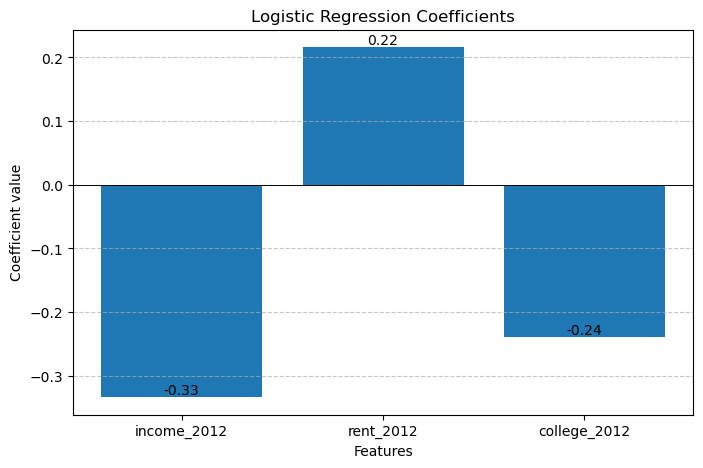

In [59]:
import matplotlib.pyplot as plt
import numpy as np

features = ['income_2012', 'rent_2012', 'college_2012']
coef = pipeline.named_steps['logisticregression'].coef_[0]

plt.figure(figsize=(8,5))
bars = plt.bar(features, coef)
plt.axhline(0, color='black', linewidth=0.7)
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient value')
plt.xlabel('Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

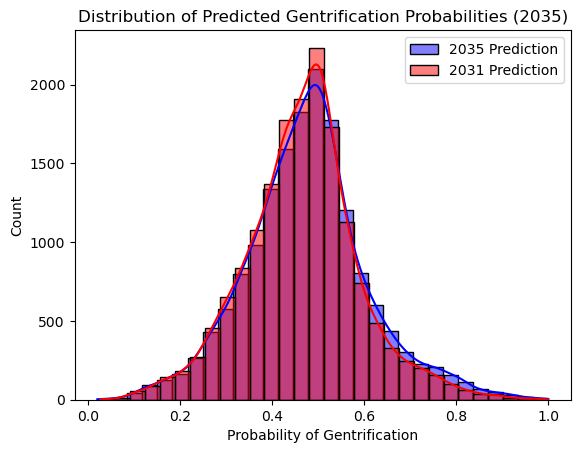

0        0.497903
1        0.427770
2        0.602468
3        0.479701
4        0.454267
           ...   
16353    0.502358
16354    0.582777
16355    0.554792
16356    0.465107
16357    0.454711
Name: gentrification_prob_2031, Length: 16358, dtype: float64

In [ ]:
import seaborn as sns

sns.histplot(df_combined['gentrification_prob_2035'], bins=30, alpha=0.5, label='2035 Prediction', color='blue', kde=True)
sns.histplot(df_combined['gentrification_prob_2031'], bins=30, alpha=0.5, label='2031 Prediction', color='red', kde=True)
plt.title('Distribution of Predicted Gentrification Probabilities (2035)')
plt.xlabel('Probability of Gentrification')
plt.ylabel('Count')
plt.legend()
plt.show()

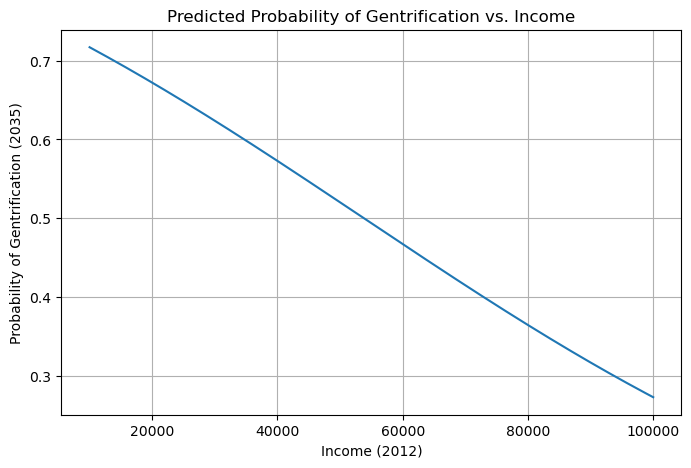

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Create a range of income values
income_range = np.linspace(10000, 100000, 500)

# Fix rent and college values at average levels
avg_rent = X_train['rent'].mean()
avg_college = X_train['college'].mean()

# Create input DataFrame
X_plot = pd.DataFrame({
    'income': income_range,
    'rent': avg_rent,
    'college': avg_college
})

# Predict probabilities using the pipeline
probs = pipeline.predict_proba(X_plot)[:, 1]

# Plot
plt.figure(figsize=(8,5))
plt.plot(income_range, probs)
plt.title('Predicted Probability of Gentrification vs. Income')
plt.xlabel('Income (2012)')
plt.ylabel('Probability of Gentrification (2035)')
plt.grid(True)
plt.show()

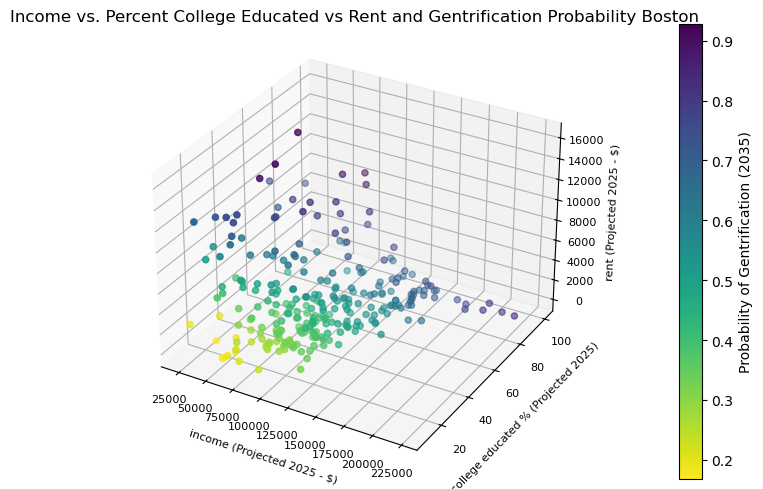

In [62]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(plt.figure(figsize=(10, 5)))
ax = fig.add_subplot(111, projection='3d')

colors = df_test_b['gentrification_prob_2035']
sc = ax.scatter(df_test_b['income_2025'], df_test_b['college_2025'], df_test_b['rent_2025'], c=colors, cmap='viridis_r')
ax.set_xlabel('income (Projected 2025 - $)', fontsize=8)
ax.set_ylabel('college educated % (Projected 2025)' , fontsize=8)
ax.set_zlabel('rent (Projected 2025 - $)' , fontsize=8)
ax.set_title('Income vs. Percent College Educated vs Rent and Gentrification Probability Boston', pad=1)
ax.tick_params(axis='both', labelsize=8) 

cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Probability of Gentrification (2035)')

plt.tight_layout()
plt.show()

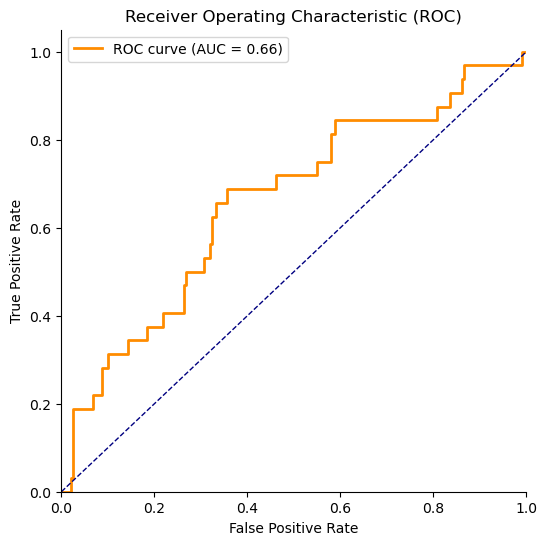

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Diagonal line
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC)')
ax.legend(loc="upper left")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()